## Regression Analysis with satellite synergy

This programme aims to use different unsupervised regression techniques to analyse the sea ice lead or melt pond fraction from colocated Sentinel-2 Optical Data and Sentinal-3 OLCI data. 

### 1. Read in Functions needed
The cell below includes all the functions needed for this notebook. Make sure to install packages using `pip install` if necessary.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import GPy
import xarray as xr

2024-06-03 10:52:09.412823: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### 2. Data preprocessing

In the previous [Colocating_S2_S3_image.ipnyb] notebook, we completed the data collection phase. We now process the data before applying regression by split the data into training and testing sets.

In [10]:
# Paths to the feature and target data files
features_path = '/Users/rhoswen/Desktop/Year_3/GEOL0069/Week_6/reshaped_array_condition.npy'
targets_path = '/Users/rhoswen/Desktop/Year_3/GEOL0069/Week_6/SICavg_condition.npy'

# Load the feature and target data
input_features = np.load(features_path)
target_variables = np.load(targets_path)

# Split the data into training and testing sets and retain indices
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(
    input_features, target_variables, np.arange(len(input_features)), test_size=0.2, random_state=42, stratify=None)

''' 
train_test_split is used to split the data into training and testing sets.
input_features and target_variables are split such that:
- X_train contains 80% of the data for training.
- X_test contains 20% of the data for testing.
- y_train contains the corresponding 80% of target values for training.
- y_test contains the corresponding 20% of target values for testing.
train_test_split is called with np.arange(len(input_features)) to obtain the indices. This ensures the indices are split alongside the features and targets.
test_size=0.2 specifies that 20% of the data should be used for the test set.
random_state=42 ensures that the split is reproducible. Using the same random_state value will produce the same split each time the code is run.
'''

# Print the shapes of the resulting arrays to verify the split
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"train_indices shape: {train_indices.shape}")
print(f"test_indices shape: {test_indices.shape}")

X_train shape: (15118, 21)
X_test shape: (3780, 21)
y_train shape: (15118,)
y_test shape: (3780,)
train_indices shape: (15118,)
test_indices shape: (3780,)


### 3. Apply different regression analysis

#### 3.1 Polynomial Regression

Polynomial regression is a form of regression analysis in which the relationship between the independent variable $x$ and the dependent variable $y$ is modeled as an $n$ th degree polynomial. Polynomial regression fits a nonlinear relationship between the value of $x$ and the corresponding conditional mean of $y$, denoted $E(y |x)$. Below code shows how we can apply it on our data.

X_poly_train shape: (15118, 253)
X_poly_test shape: (3780, 253)
y_pred_poly shape: (3780,)
The Mean Squared Error (MSE) on the test set is: 0.0032163320756796823


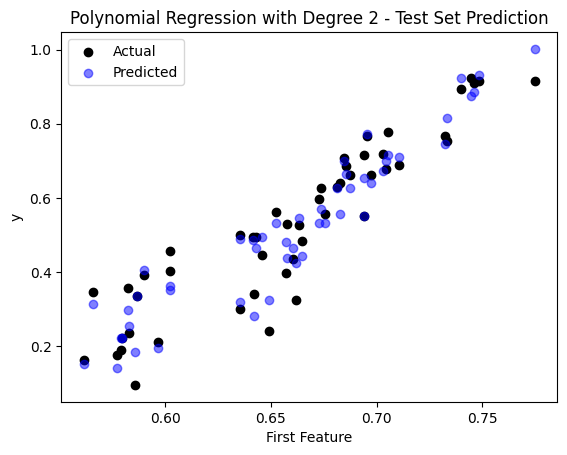

In [11]:
# Polynomial Feature Transformation
polynomial_features = PolynomialFeatures(degree=2)
X_poly_train = polynomial_features.fit_transform(X_train)
X_poly_test = polynomial_features.transform(X_test)

# Train Polynomial Regression Model
model_poly = LinearRegression()
model_poly.fit(X_poly_train, y_train)

# Predict and Evaluate
y_pred_poly = model_poly.predict(X_poly_test)

# Check the data shape
print(f'X_poly_train shape:',X_poly_train.shape)
print(f'X_poly_test shape:',X_poly_test.shape)
print(f'y_pred_poly shape:',y_pred_poly.shape)

# Compute mean square error between the predicted and actual test data
mse = mean_squared_error(y_test, y_pred_poly)
print(f"The Mean Squared Error (MSE) on the test set is: {mse}")

# Visualize the Results
# A random sample of 50 points is selected from the test set for visualization.
sample_idx = np.random.choice(np.arange(len(y_test)), size=50, replace=False)
plt.scatter(X_test[sample_idx,0], y_test[sample_idx], color='black', label='Actual')
plt.scatter(X_test[sample_idx,0], y_pred_poly[sample_idx], color='blue', label='Predicted', alpha=0.5)
plt.title('Polynomial Regression with Degree 2 - Test Set Prediction')
plt.xlabel('First Feature')
plt.ylabel('y')
plt.legend()
plt.show()

Now we can test our model on the OLCI image.

In [14]:
# Replace the path
path = '/Users/rhoswen/Desktop/Year_3/GEOL0069/Week_6/'

# Load the OLCI image data
x_s3_condition = np.load(path+'x_s3_condition.npy')
y_s3_condition = np.load(path+'y_s3_condition.npy')

# Check shapes
print(f'x_s3_condition shape:',x_s3_condition.shape)
print(f'y_s3_condition shape:',y_s3_condition.shape)

# Split the dataset using the same test indices
x_test_data = x_s3_condition[test_indices]
y_test_data = y_s3_condition[test_indices]

# Check shapes
print(f'x_s3_data shape:',x_test_data.shape)
print(f'y_s3_data shape:',y_test_data.shape)


x_s3_condition shape: (18898,)
y_s3_condition shape: (18898,)
x_s3_data shape: (3780,)
y_s3_data shape: (3780,)


In [ ]:
# Rollout the image
plt.scatter(x_test_data,y_test_data,c=y_pred_poly,vmin=0,vmax=1)
plt.colorbar()

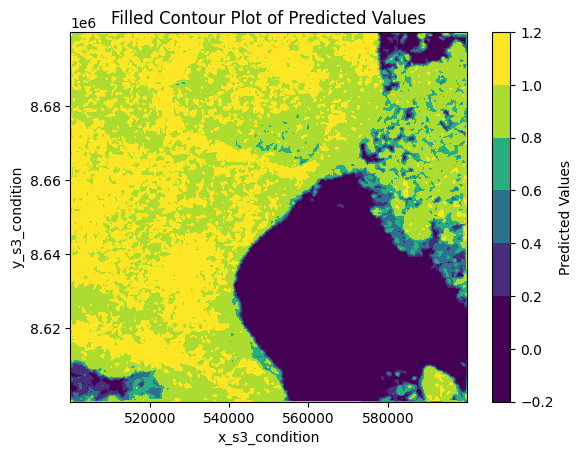

In [190]:
# Try different type of plot and decide better visualisation
# plt.hist2d(x_test_data, y_test_data, bins=100, weights=y_pred_poly, cmap='viridis')
# plt.hexbin(x_test_data, y_test_data, C=y_pred_poly, gridsize=50, cmap='viridis')
plt.tricontourf(x_test_data, y_test_data, y_pred_poly, cmap='viridis', vmin=0.2,vmax=1)
plt.colorbar(label='Predicted Values')
plt.title('Filled Contour Plot of Predicted Values')
plt.xlabel('x_s3_condition')
plt.ylabel('y_s3_condition')
plt.show()


#### 3.2 Neural Networks (NN)

Neural Networks are a set of algorithms, modeled loosely after the human brain, designed to recognize patterns. They interpret sensory data through a kind of machine perception, labeling, or clustering raw input. The patterns they recognize are numerical, contained in vectors, into which all real-world data, be it images, sound, text, or time series, must be translated.

Epoch 1/10
473/473 [==============================] - 2s 2ms/step - loss: 0.0150
Epoch 2/10
473/473 [==============================] - 1s 2ms/step - loss: 0.0084
Epoch 3/10
473/473 [==============================] - 1s 2ms/step - loss: 0.0067
Epoch 4/10
473/473 [==============================] - 1s 2ms/step - loss: 0.0058
Epoch 5/10
473/473 [==============================] - 1s 2ms/step - loss: 0.0056
Epoch 6/10
473/473 [==============================] - 1s 2ms/step - loss: 0.0050
Epoch 7/10
473/473 [==============================] - 1s 2ms/step - loss: 0.0050
Epoch 8/10
473/473 [==============================] - 1s 2ms/step - loss: 0.0049
Epoch 9/10
473/473 [==============================] - 1s 2ms/step - loss: 0.0049
Epoch 10/10
119/119 [==============================] - 0s 930us/step
The Mean Squared Error (MSE) on the test set is: 0.06665795484051028
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape      

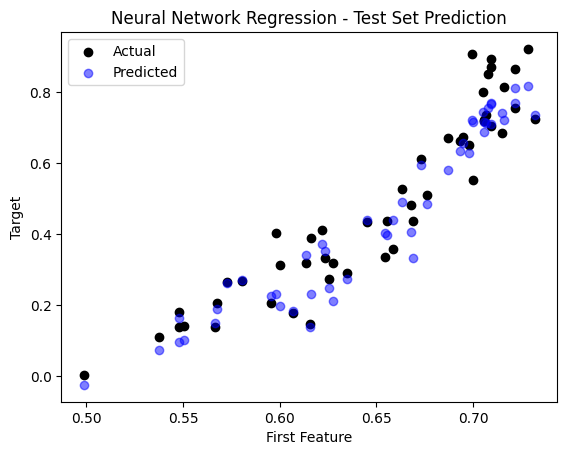

In [15]:
# Model definition and compilation
model_nn = Sequential([
    Dense(256, activation='relu', input_shape=(21,)),
    Dense(256, activation='relu'),
    Dense(1)
])

model_nn.compile(optimizer='adam', loss='mean_squared_error')

# Training the model
model_nn.fit(X_train, y_train, epochs=10)

# Making predictions and evaluating the model with mean squared error
y_pred = model_nn.predict(X_test)

mse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"The Mean Squared Error (MSE) on the test set is: {mse}")

# Model architecture summary
model_nn.summary()

# Flattening predictions
y_pred_nn = y_pred.flatten()

# Visualize the predictions
sample_idx = np.random.choice(np.arange(len(y_test)), size=50, replace=False)
plt.scatter(X_test[sample_idx, 0], y_test[sample_idx], color='black', label='Actual')
plt.scatter(X_test[sample_idx, 0], y_pred_nn[sample_idx], color='blue', label='Predicted', alpha=0.5)
plt.title('Neural Network Regression - Test Set Prediction')
plt.xlabel('First Feature')
plt.ylabel('Target')
plt.legend()
plt.show()


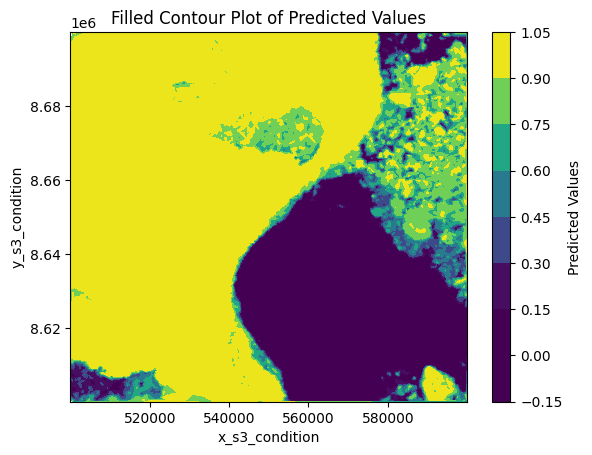

In [194]:
# Visualize model on OLCI image
plt.tricontourf(x_test_data, y_test_data, y_pred_nn, cmap='viridis', vmin=0.2,vmax=1)
plt.colorbar(label='Predicted Values')
plt.title('Filled Contour Plot of Predicted Values')
plt.xlabel('x_s3_condition')
plt.ylabel('y_s3_condition')
plt.show()

#### 3.3 Gaussian Processes

In mathematical terms, a Gaussian Process (GP) is defined for a set of function values, where these values follow a Gaussian distribution. Specifically, for any selection of points from a set $X$, the values that a function $f$ takes at these points follow a joint Gaussian distribution.

In [16]:
# Importing and setting up the kernel which defines the Radial Basis Function (RBF)
kernel = GPy.kern.RBF(input_dim=21)
num_inducing = 100

# Creating and optimizing the model
gp = GPy.models.SparseGPRegression(X_train, y_train.reshape(-1, 1), kernel, num_inducing=num_inducing)

gp.optimize(messages=True)

# Making predictions
y_pred_gp, variance = gp.predict(X_test)
y_pred_gp = y_pred.flatten()
sigma = np.sqrt(variance).flatten()

# Evaluating the model with mean squared error
mse = mean_squared_error(y_test, y_pred_gp)
print(f"The Mean Squared Error (MSE) on the test set is: {mse}")

# Visualizing the results
sample_idx = np.random.choice(np.arange(len(y_test)), size=50, replace=False)
plt.scatter(X_test[sample_idx, 0], y_test[sample_idx], color='black', label='Actual')
plt.scatter(X_test[sample_idx, 0], y_pred_gp[sample_idx], color='blue', label='Predicted', alpha=0.5)
plt.title('Gaussian Process Regression - Test Set Prediction')
plt.xlabel('First Feature')
plt.ylabel('Target')
plt.legend()
plt.show()


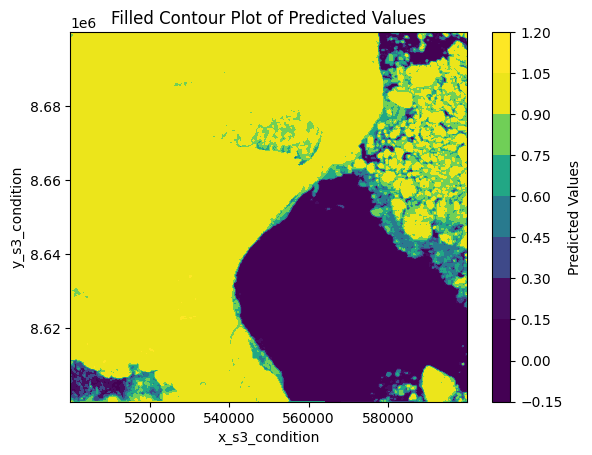

In [182]:
# Visualize model on OLCI image
plt.tricontourf(x_test_data, y_test_data, y_pred_gp, cmap='viridis', vmin=0.2,vmax=1)
plt.colorbar(label='Predicted Values')
plt.title('Filled Contour Plot of Predicted Values')
plt.xlabel('x_s3_condition')
plt.ylabel('y_s3_condition')
plt.show()

### 4. Comparison of regression techniques performance

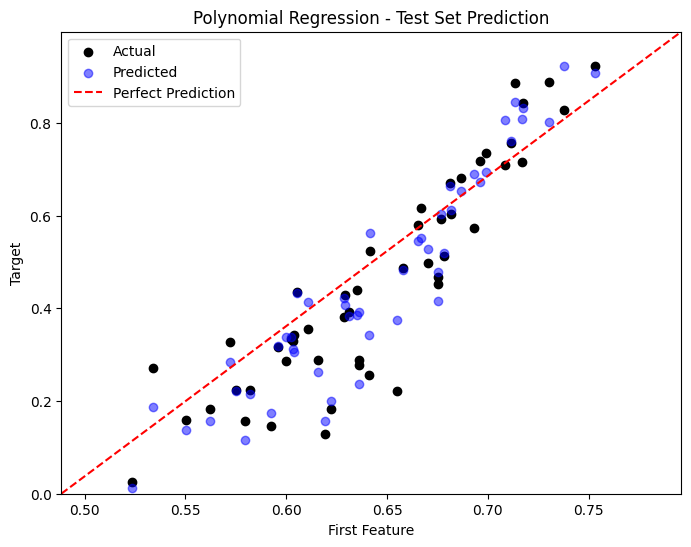

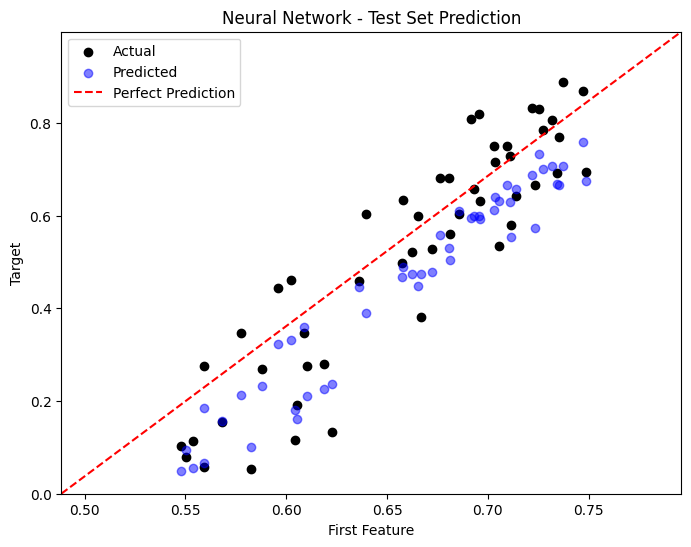

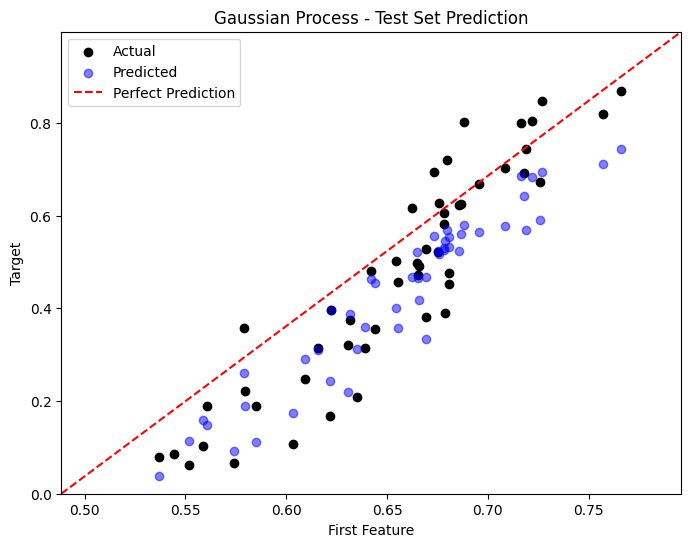

In [160]:
# Define the minimum and maximum values for the first feature in the test set and the target variable
x_min, x_max = X_test[:, 0].min(), X_test[:, 0].max()
y_min, y_max = y_test.min(), y_test.max()

# List of prediction results from different models
predictions = [y_pred_poly, y_pred_nn, y_pred_gp]
titles = ['Polynomial Regression', 'Neural Network', 'Gaussian Process']

# Iterate over the prediction results and titles
for i, y_pred in enumerate(predictions):
    plt.figure(figsize=(8, 6))
    sample_idx = np.random.choice(np.arange(len(y_test)), size=50, replace=False)
    plt.scatter(X_test[sample_idx, 0], y_test[sample_idx], color='black', label='Actual')
    plt.scatter(X_test[sample_idx, 0], y_pred[sample_idx], color='blue', label='Predicted', alpha=0.5)
    plt.plot([x_min, x_max], [y_min, y_max], 'r--', label='Perfect Prediction')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.title(titles[i] + ' - Test Set Prediction')
    plt.xlabel('First Feature')
    plt.ylabel('Target')
    plt.legend()
    plt.show()

### 5. Referencing Melt Pond Fraction (MPF)
The code below visualizes the melt pond fraction products deriving from Sentinel-2 image (data obtained from H. Niehaus et al., 2023), which can act as a reference and comparison to our predicted models and rollout image.

<xarray.Dataset> Size: 115MB
Dimensions:  (y: 6000, x: 2400)
Coordinates:
  * y        (y) int32 24kB 8675995 8675985 8675975 ... 8616025 8616015 8616005
  * x        (x) int32 10kB 499985 499995 500005 500015 ... 523955 523965 523975
Data variables:
    crs      int8 1B ...
    mpf      (y, x) float32 58MB ...
    ow       (y, x) float32 58MB ...
Attributes:
    author:       University of Bremen, Gunnar Spreen [gunnar.spreen@uni-brem...
    Conventions:  CF-1.5
    title:        Sentinel-2 Melt Pond Fraction
    info:         Pixelwise derived melt pond fraction from Sentinel-2 bands ...
    date:         20180610
    time:         063629
    zone:         48N
    epsg:         32648
<xarray.DataArray 'mpf' (y: 6000, x: 2400)> Size: 58MB
[14400000 values with dtype=float32]
Coordinates:
  * y        (y) int32 24kB 8675995 8675985 8675975 ... 8616025 8616015 8616005
  * x        (x) int32 10kB 499985 499995 500005 500015 ... 523955 523965 523975
Attributes:
    grid_mapping:   crs
   

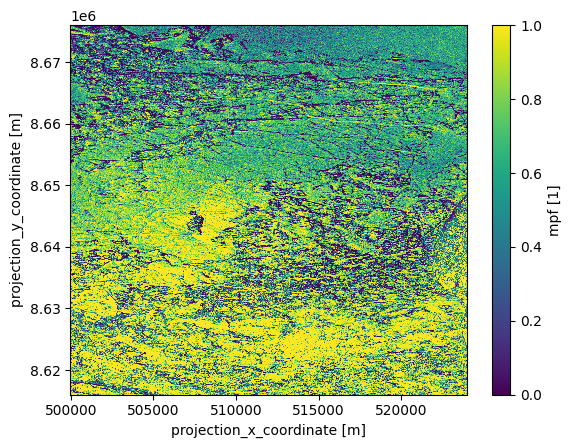

In [13]:
# Load the NetCDF file
file_path = '/Users/rhoswen/Desktop/Year_3/GEOL0069/Week_6/20180610_T48XWM_s2_mpf.nc'
ds = xr.open_dataset(file_path)

# Print dataset information
print(ds)

# Select a variable to visualize
# Replace 'variable_name' with the actual variable name you want to visualize
variable = ds['mpf']

# Print variable information
print(variable)

# Plot the variable
variable.plot()

# Show the plot
plt.show()